# **Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


# **Necessary Imports**

In [3]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import pandas as pd
import shutil
from glob import glob
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# **Pre-procesing using Generators**

In [4]:
# re-size all the images to this
image_size = 224
batch_size = 32

source_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset"
train_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Test"
validate_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Validate"

# Define data generators for train, validation, and test sets
Train_Datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
Val_Datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
Test_Datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Create train, validation, and test generators
batch_size = 32
train_generator = Train_Datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='binary')
val_generator = Val_Datagen.flow_from_directory(validate_dir, target_size=(224, 224), batch_size=batch_size, class_mode='binary')
test_generator = Test_Datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='binary')

Found 810 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
# Get a batch of data from the generator
batch_train_images, batch_train_labels = next(train_generator)
batch_val_images, batch_val_labels = next(val_generator)
batch_test_images, batch_test_labels = next(test_generator)

# Check the shape of the batch data
print("Shape of training batch images:", batch_train_images.shape)
print("Shape of training batch labels:", batch_train_labels.shape)
print("Shape of validation batch images:", batch_val_images.shape)
print("Shape of validation batch labels:", batch_val_labels.shape)
print("Shape of testing batch images:", batch_test_images.shape)
print("Shape of testing batch labels:", batch_test_labels.shape)

Shape of training batch images: (32, 224, 224, 3)
Shape of training batch labels: (32,)
Shape of validation batch images: (32, 224, 224, 3)
Shape of validation batch labels: (32,)
Shape of testing batch images: (32, 224, 224, 3)
Shape of testing batch labels: (32,)


In [6]:
train_generator.class_indices

{'no': 0, 'yes': 1}

# **Model**

In [7]:
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create a Sequential model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Add Flatten layer
model.add(Flatten())

# Add Dense layers with Dropout for preventing overfitting
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                         

# **CheckPoints Calls**

In [8]:
# Specify the path where you want to create the directory and file
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/vgg16_checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

In [9]:
# Define callbacks for model saving and logging
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'model_{epoch:02d}.h5'),
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)


# **Training** 

In [10]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 12.7136 - accuracy: 0.6362
Epoch 1: val_loss improved from inf to 0.69280, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/vgg16_checkpoints/model_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 152s 6s/step - loss: 12.7136 - accuracy: 0.6362 - val_loss: 0.6928 - val_accuracy: 0.8750
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 2.6899 - accuracy: 0.8522
Epoch 2: val_loss improved from 0.69280 to 0.41229, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/vgg16_checkpoints/model_02.h5
25/25 [==============================] - 20s 772ms/step - loss: 2.6899 - accuracy: 0.8522 - val_loss: 0.4123 - val_accuracy: 0.9583
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.0473 - accuracy: 0.9126
Epoch 3: val_loss did not improve from 0.41229
25/25 [==============================] - 21s 821ms/step - loss: 1.0473 - accuracy: 0.9126 - val_loss: 0.7028 - val_accuracy: 0.9271
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.7214 - accuracy: 0.9344
Epoch 4: val_loss did not improve from 0.41229
25/25 [==============================] - 20s 808ms/step - loss: 0.7214 - accuracy: 0

# **Model Saved**

In [11]:
# Save the model to Google Drive
model.save('/content/drive/MyDrive/Colab Notebooks/Dataset/Trained_model/model_vgg16_gen.h5')


# **Test Data Evaluation**

In [12]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


4/4 [==============================] - 22s 7s/step - loss: 0.3110 - accuracy: 0.9800
Test Accuracy: 0.9800000190734863


# **Line Plots for Training Summary**

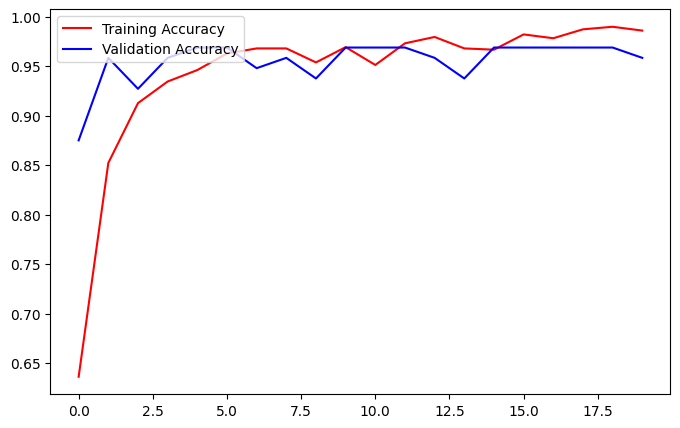

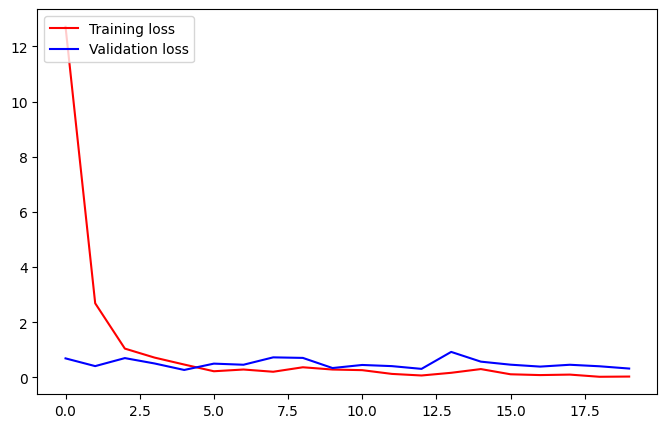

In [13]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()
# plt.savefig('AccVal_acc')

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.legend(loc='upper left')
plt.show()
# plt.savefig('LossVal_loss')

# **Test Data Prediction**

In [17]:
# Assuming you have trained your model and defined the test_generator

# Get one batch of test data
test_data, test_labels = test_generator.next()

# Predict the labels for the test data
predictions = model.predict(test_data)

# Convert the predicted probabilities to class labels (0 or 1)
predicted_labels = np.round(predictions)

# Print the predicted labels and the true labels
print("Predicted Labels:", predicted_labels.flatten())
print("True Labels:", test_labels.flatten())



1/1 [==============================] - 1s 624ms/step
Predicted Labels: [1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 1.]
True Labels: [1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 1.]


1/1 [==============================] - 0s 75ms/step


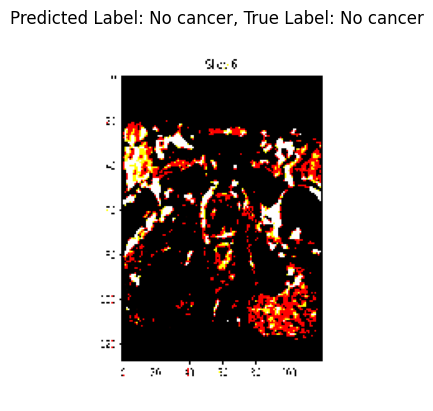

In [22]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Assuming you have trained your model and defined the test_generator

# Get one batch of test data
test_data, test_labels = test_generator.next()

# Get a random index within the batch size
random_index = np.random.randint(0, test_data.shape[0])

# Get the random image and its corresponding label
random_image = test_data[random_index]
true_label = test_labels[random_index]

# Expand the dimensions of the image to match the input shape expected by the model
random_image = np.expand_dims(random_image, axis=0)

# Predict the label for the random image
predicted_label = model.predict(random_image)
predicted_label = np.round(predicted_label)

# Convert label to human-readable format (0: No cancer, 1: Yes cancer)
labels_dict = {0: "No cancer", 1: "Yes cancer"}
predicted_label_str = labels_dict[int(predicted_label)]
true_label_str = labels_dict[int(true_label)]

# Display the random image
plt.imshow(random_image.squeeze(),  cmap='gray')
plt.title(f"Predicted Label: {predicted_label_str}, True Label: {true_label_str}")
plt.axis('off')
plt.show()


# **Model Loaded and Test Random Prediction**

In [23]:
from tensorflow.keras.models import load_model
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/Dataset/Trained_model/model_vgg16_gen.h5')

1/1 [==============================] - 0s 76ms/step


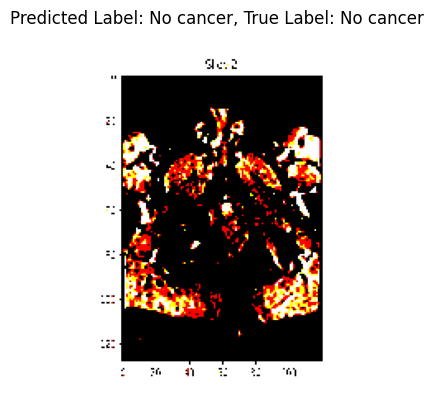

In [27]:
# Get one batch of test data
test_data, test_labels = test_generator.next()

# Get a random index within the batch size
random_index = np.random.randint(0, test_data.shape[0])

# Get the random image and its corresponding label
random_image = test_data[random_index]
true_label = test_labels[random_index]

# Expand the dimensions of the image to match the input shape expected by the model
random_image = np.expand_dims(random_image, axis=0)

# Predict the label for the random image
predicted_label = loaded_model.predict(random_image)
predicted_label = np.round(predicted_label)

# Display the random image
plt.imshow(random_image.squeeze(), cmap='gray')
plt.title(f"Predicted Label: {predicted_label_str}, True Label: {true_label_str}")
plt.axis('off')
plt.show()